# Exercise 5: Sinusoidal model

In this exercise you will experiment with the sinusoidal model, measuring and tracking sinusoids in different kinds of audio signals. You will use the sinusoidal model to analyze short synthetic sounds with the goal to better understand various aspects of sinusoid estimation and tracking. You will experiment with different parameters and enhancements of the sinusoidal modeling approach. 

There are five parts in this exercise: 1) Minimizing the frequency estimation error of a sinusoid, 2) Tracking a two component chirp, 3) Tracking sinusoids of different amplitudes, 4) Tracking sinusoids using the phase spectrum, and 5) Sinusoidal modeling of a multicomponent signal.

### Relevant Concepts

__Chirp signals:__
A chirp is a signal whose frequency varies with time. In an up-chirp, the frequency increases in time. In Part 2 of the exercise, we will use a synthetically generated linear chirp with two frequency components. The frequency components are very close to each other and to resolve the two components, you need to use a large window. However, the frequency of a chirp continuously changes, which implies that we need a shorter window for analysis to capture this continuously changing frequency. Hence, there exists a tradeoff between the best set of sinusoidal analysis parameters to achieve a good tracking of the two components of the chirp. 

__Sinusoidal modeling and sine tracking:__ 
Sinusoidal modeling aims to model each frame of audio with a set of sinusoids, from which we can reconstruct the input audio with minimum reconstruction error. The basic peak detection task performed in the spectrum of a frame can be enhanced in many ways to obtain the most compact representation possible and the most meaningful one for a particular task. One of the enhancements implemented in sms-tools is the tracking of the estimated sinusoids over time. In sounds with stable notes, the sinusoids tend to last over several frames and this can be used to discard spurious sinusoids that have been estimated. There are two functions in `sineModel.py` that together perform sine tracking. The function `sineTracking()` tracks peaks from one frame to the next, to give tracks of the sinusoids in time. The function `cleaningSineTracks()` then cleans up the tracks by discarding short spurious sinusoids based on a length threshold. These functions use the following parameters to do sine tracking. 

1. `maxnSines`: Maximum number of sines tracked per frame.
2. `minSineDur`: Minimum duration of a sinusoidal track in seconds.
3. `freqDevOffset`: The minimum frequency deviation at 0Hz. Since the frequency of sinusoidal tracks can change slowly over time, it is necessary to have a margin of allowed deviation to track the change over time. 
4. `freqDevSlope`: Slope increase of minimum frequency deviation. The common deviations are  more pronounced at higher frequency and we compensate for that using a scaling factor, which provides a higher deviation allowance at higher frequencies. 

If we set `minSineDur = 0`, it retains all the spectral peaks detected. `maxnSines` can be set according to our prior knowledge about the number of sinusoids present in the signal. `freqDevOffset` intuitively can be set to be the minimum distance between two consecutive sinusoids (or harmonics in the case of harmonic sounds).

__Tracking low amplitude sinusoids:__
Tracking sinusoids of low amplitude among other sinusoids of high amplitude presents several challenges. In a signal that has two sinusoidal components with a very large difference in their amplitude, the analysis window we use is critical. If we use a window that has high sidelobe levels, the mainlobe of the sinusoid with low amplitude might get buried under the sidelobes of the dominant high amplitude sinusoid. When the amplitude difference is huge you need to choose a window that will ensure that the sidelobe levels of the louder sinusoid is lower than the mainlobe level of the softer sinusoid. 

__Using Phase to track sinusoid peaks:__
Zero-phase windowing a sinusoidal signal leads to a phase spectrum that is flat around the bins corresponding to the frequency of the sinusoid. This property of flatness of the phase spectrum can be used to identify and track sinusoidal peaks. This can be an alternative, or a complementary way to the identification of sinusoids by just measuring local maxima in the magnitude spectrum. We can pick local maxima in the magnitude spectrum and also measure the variance of the phase spectrum around the local maximum to select or discard a particular spectral peak. However, it is to be noted that this condition of flatness is satisfied only when the sinusoid is not time varying. For strongly time-varying sinusoids, the condition fails. 

## Part 1 - Minimizing the frequency estimation error of a sinusoid

Complete function `min_freq_est_err()` to estimate the frequency of a sinusoidal signal at a given time instant. The 
function should return the estimated frequency in Hz, together with the window size and the FFT size used in the analysis.  

The input arguments to the function are the wav file name including the path (`input_file`) containing the sinusoidal signal, and the frequency of the sinusoid in Hz (`f`). The frequency of the input sinusoid can range between 100Hz and 2000Hz. The function should return a three element tuple of the estimated frequency of the sinusoid (`f_est`), the window size (`M`), and the FFT size (`N`) used.

The input wav file should be a stationary audio signal consisting of a single sinusoid of length >=1 second. Since the signal is stationary you can just perform the analysis of a single frame, for example in the middle of the sound file (time equal to .5 seconds). The analysis process would be to first select a fragment of the signal equal to the window size, `M`, centered at .5 seconds, then compute the DFT using the `dftAnal()` function, and finally use the `peakDetection()` and `peakInterp()` functions to obtain the frequency value of the sinusoid.

Use a Blackman window for analysis and a magnitude threshold `t = -40`dB for peak picking. The window size and FFT size should be chosen such that the difference between the true frequency (`f`) and the estimated frequency (`fEst`) is less than 0.05 Hz for the entire allowed frequency range of the input sinusoid. The window size should be the minimum positive integer of the form `100*k + 1` (where `k` is a positive integer) for which the frequency estimation error is < 0.05Hz. For a window size `M`, take the FFT size (`N`) to be the smallest power of 2 larger than `M`. 

HINT: Computing `M` theoritically using a formula might be complex in such cases. Instead, you need to 
follow a heuristic approach to determine the optimal value of `M` and `N` for a particular `f`. You can iterate
over all allowed values of window size `M` and stop when the condition is satisfied (i.e. the frequency estimation error < 0.05 Hz).

In [1]:
import numpy as np
from scipy.signal import get_window
import math
import sys, os
sys.path.append('../software/models/')
import dftModel as DFT
import utilFunctions as UF
import stft
import sineModel as SM

In [2]:
def min_freq_est_err(input_file, f):
    """
    Inputs:
            input_file (string) = wav file including the path
            f (float) = frequency of the sinusoid present in the input audio signal (Hz)
    Output:
            f_est (float) = Estimated frequency of the sinusoid (Hz)
            M (int) = Window size
            N (int) = FFT size
    """
    # analysis parameters:
    window = 'blackman'
    t = -40
    
    ### Your code here
    fs,x = UF.wavread(input_file)
    
    for M in range(101,x.size,100):
        w = get_window(window, M)
        xs = x[(fs-M)//2:(fs+M)//2]
        N = 2**M.bit_length() 
        mX,pX = DFT.dftAnal(xs,w,N)
        ploc = UF.peakDetection(mX, t)
        iploc, ipmag, ipphase = UF.peakInterp(mX, pX, ploc)
        f_est = fs*iploc/N
        if abs(f-f_est)<0.05:
            break
            
    return f_est,M,N

In [3]:
min_freq_est_err('../sounds/sine-490.wav',490)

(array([489.96301834]), 1101, 2048)

In [4]:
min_freq_est_err('../sounds/sine-1000.wav',1000)

(array([1000.01994259]), 1101, 2048)

In [5]:
min_freq_est_err('../sounds/sine-200.wav',200)

(array([200.03811968]), 1201, 2048)

Now run an test `min_freq_est_err()`. You can use the following test cases to check your function.

__Test case 1:__ If you run your code with `input_file = '../sounds/sine-490.wav'`, `f = 490.0` Hz, the optimal
values are `M = 1101`, `N = 2048`, `f_est = 489.963` and the freqency estimation error is 0.037.

__Test case 2:__ If you run your code with `input_file = '../sounds/sine-1000.wav'`, `f = 1000.0` Hz, the optimal
values are `M = 1101`, `N = 2048`, `f_est = 1000.02` and the freqency estimation error is 0.02.

__Test case 3:__ If you run your code with `input_file = '../sounds/sine-200.wav'`, `f = 200.0 Hz`, the optimal
values are `M = 1201`, `N = 2048`, `f_est = 200.038` and the freqency estimation error is 0.038.

Interesting validation is to check if these frequency estimation errors are perceptually relevant. To do that you can generate and listen the estimated frequencies, by generating a sinusoid with that frequency, and check if you perceive a difference with the original sinusoid.

In [6]:
def gen_sine(A, f, phi, fs, t):
    return A*np.cos((2*np.pi*np.arange(fs*t)*f/fs+phi))

fs,x = UF.wavread('../sounds/sine-490.wav')
import IPython.display as ipd
ipd.display(ipd.Audio(data=x,rate=fs))
y = gen_sine(1,489.963, 0, 44100, 1)
ipd.display(ipd.Audio(data=y,rate=fs))

## Part 2 - Tracking a two component chirp 

Perform the best possible sinusoidal analysis of a two component chirp signal by focusing on the window-size, `M` of the function `sineModelAnal()`. 

You should use the sound `chirp-150-190-linear.wav`, which is a linear chirp with two sinusoids with starting frequencies of 150Hz and 190Hz, and finishing at 1400Hz and 1440Hz after 2 seconds. The estimation and tracking of the two varying frequencies should result in a mean error smaller than 2Hz. 

Several functions are already defined to do this part of the exercise. Read them and understand what they do. The function `freq_tracker_error()` performs a sinusoidal analysis using the `sineModelAnal()` function, then compares the analysis results, `fTrackEst`, with the ideal frequency values, given as input, and returns the mean error `meanErr`. 

Get familiar with the signal by listening to the sound and visualizing its spectrogram. Use `models_GUI.py` interface or sonic visualizer to see its spectrogram. 

In [7]:
def freq_tracker_error(input_file, fTrackTrue, window, t, H, M):
    """
    Input:
           input_file (string) = wav file including the path
           fTrackTrue (2D numpy array) = numpy array of true frequency values, one row per time frame, one column per component
           window (string): window type used for analysis
           t (float) = peak picking threshold (negative dB)
           H = hop size in samples
           M = window size in samples
   Output:
           fTrackEst (numpy array) = A Kx2 numpy array of estimated frequency values, one row per time frame, one column per component
    """
  
    N = int(pow(2, np.ceil(np.log2(M))))        # FFT Size, power of 2 larger than M
    maxnSines = 2                               # Maximum number of sinusoids at any time frame
    minSineDur = 0.0                            # minimum duration set to zero to not do tracking
    freqDevOffset = 30                          # minimum frequency deviation at 0Hz
    freqDevSlope = 0.001                        # slope increase of minimum frequency deviation
    
    fs, x = UF.wavread(input_file)              # read input sound
    w = get_window(window, M)                   # Compute analysis window
    # analyze the sound with the sinusoidal model
    fTrackEst, mTrackEst, pTrackEst = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)
    tailF = 20                                 
    # Compute mean estimation error. 20 frames at the beginning and end not used to compute error
    meanErr = np.mean(np.abs(fTrackTrue[tailF:-tailF,:] - fTrackEst[tailF:-tailF,:]),axis=0)     
    #print ("Mean estimation error = " + str(meanErr) + ' Hz')      # Print the error to terminal    
    
    return fTrackEst,meanErr  # Output returned 

def gen_time_stamps(xlen, M, fs, H):
    # Generates the time stamps as needed for output
    hM1 = int(np.floor((M+1)/2))                     
    hM2 = int(np.floor(M/2))                         
    xlen = xlen + 2*hM2
    pin = hM1
    pend = xlen - hM1                                     
    tStamps = np.arange(pin,pend,H)/float(fs)
    return tStamps

def gen_true_freq_tracks_chirp_150_190(tStamps):
    # Generates the true frequency values to compute estimation error
    # Specifically to chirp-150-190-linear.wav
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = np.transpose(np.linspace(190, 190+1250, len(tStamps)))
    fTrack[:,1] = np.transpose(np.linspace(150, 150+1250, len(tStamps)))
    return fTrack

def gen_true_freq_tracks_440_602(tStamps):
    # Generates the true frequency values to compute estimation error
    # Specifically to sines-440-602-hRange.wav
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = np.transpose(440*np.ones((len(tStamps),1)))
    fTrack[:,1] = np.transpose(602*np.ones((len(tStamps),1)))
    return fTrack

To do this exercise complete the next cell. Run the function `freq_tracker_error()` giving a value for the window-size, `M` to obtain the best possible results, minimum error. Use the given values for the rest of parameters.

Choose `M` such that the mean estimation error (`meanErr`) of each frequency component is less than 2Hz. There is a range of values of `M` for which this is true and all of those values will be considered correct answers. You can plot the estimated and true frequency tracks to visualize the accuracy of estimation.

The function `gen_time_stamps()` generates the time stamps as needed for comparing the true and the estimated frequency values. The function `gen_true_freq_tracks()` generates the true frequency values of `chirp-150-190-linear.wav`, so that we can compare the true and the estimated frequency values. 

NOTE: Do not do just trial and error. Understand the problem and calculate the `M` that should work best. Then test it and refine the answer using the code.

__Test case:__ Choosing `M = 1023`, the mean estimation error should be `[13.669,  528.533]` Hz, which as you can see do not give us the desired estimation errors.

In [8]:
import matplotlib.pyplot as plt

H = 128 
window = 'blackman'
t = -80
input_file = '../sounds/chirp-150-190-linear.wav'
fs, x = UF.wavread(input_file) 
M = 4100    # 6*fs//(190-150)
tStamps = gen_time_stamps(x.size, M, fs, H)   # Generate the tStamps to return
fTrackTrue = gen_true_freq_tracks_chirp_150_190(tStamps)

### Your code here
est,meanErr = freq_tracker_error(input_file, fTrackTrue, window, t, H, M)
print ("Mean estimation error = " + str(meanErr) + ' Hz')
plt.figure(1, figsize=(20, 15))
plt.subplot(211)
plt.plot(fTrackTrue)
plt.subplot(212)
plt.plot(est)

Mean estimation error = [0.67791612 1.21191395] Hz


In [9]:
meanErr = np.zeros((99,2))
for M in range(100,10000,100):
    tStamps = gen_time_stamps(x.size, M, fs, H)
    fTrackTrue = gen_true_freq_tracks_chirp_150_190(tStamps)
    est,meanErr[M//100-1,:] = freq_tracker_error(input_file, fTrackTrue, window, t, H, M)

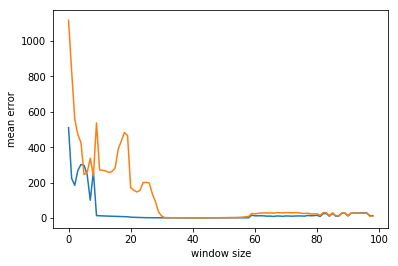

In [10]:
plt.xlabel('window size')
plt.ylabel('mean error')
plt.plot(meanErr[:,0])
plt.plot(meanErr[:,1])
plt.show()

## Part 3 -Tracking sinusoids of different amplitudes 

Perform the best possible sinusoidal analysis of a signal with two sinusoidal components of different amplitudes 
by focusing on the type of window `window` and the magnitude threshold `t` of the function `sineModelAnal()`. 

Use the input signal `sines-440-602-hRange.wav` which includes two sinusoidal components with a very large difference in their amplitude. It is a synthetically generated signal with frequency components 440Hz and 602Hz, `s = sin(2*pi*440*t) + 2e-3*sin(2*pi*602*t)`. 

This part uses the same functions as Part 2.

Get familiar with the signal by listening to it and visualizing its spectrogram. Use `models_GUI.py` interface or sonic visualizer to see its spectrogram. Notice the difference in the amplitudes of its components.

To do this exercise complete the next cell. Run the function `freq_tracker_error()` giving a value for the window type `window` and the  magnitude threshold `t`. Use the given values for the rest of parameters.

For the `sineModelAnal()` function we use a window length `M = 2047` samples, an FFT size `N = 4096` samples, and a hop size `H = 128` samples. For sine tracking, we set `minSineDur = 0.02` seconds, `freqDevOffset = 10`Hz, and `freqDevSlope = 0.001` (its default value). Since we need only two frequency component estimates at every frame, we set `maxnSines = 2`. 

Set the input parameters `window` and `t` such that the mean estimation error of each frequency components is less than 2Hz. There is a range of values of `M` and `t` for which this is true and all of those values will be considered correct answers. You can plot the estimated and true frequency tracks to visualize the accuracy of estimation. The output is the set of parameters you used: `window`, `t`, the time stamps, estimated and the true frequency tracks. Note that choosing the wrong window might lead to tracking of one of the sidelobes of the high amplitude sinusoid instead of the mainlobe of the low amplitude sinusoid. 

For the window, choose one of `'boxcar'`, `'hanning'`, `'hamming'`, `'blackman'`, or `'blackmanharris'`. `t` should be specified in negative dB.

NOTE: Do not do just trial and error. Understand the problem and calculate and `M` that should work. Then test it and refine the answer.

__Test case:__ Choosing `window = 'boxcar'`, `t = -80.0`, the mean estimation error is `[0.19603701  29.51140815]` Hz. 


Mean estimation error = [0.03843794 0.06193923] Hz


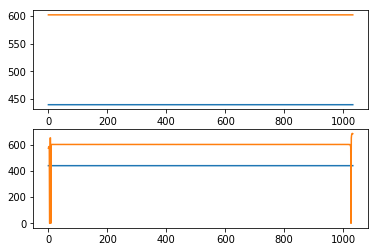

In [11]:
M = 2047                                             # Window size 
N = 4096                                             # FFT Size
H = 128                                              # Hop size in samples
input_file = '../sounds/sines-440-602-hRange.wav'
fs, x = UF.wavread(input_file)  
tStamps = gen_time_stamps(x.size, M, fs, H)   # Generate the tStamps to return
fTrackTrue = gen_true_freq_tracks_440_602 (tStamps)

### Your code here
window = 'blackmanharris'
t = -65.0
est,meanErr = freq_tracker_error(input_file, fTrackTrue, window, t, H, M)
print ("Mean estimation error = " + str(meanErr) + ' Hz')
plt.subplot(211)
plt.plot(fTrackTrue)
plt.subplot(212)
plt.plot(est)

## Part 4 - Tracking sinusoids using the phase spectrum

Complete the function `select_flat_phase_peak()` to select a sinusoidal peak based on the flatness of the phase spectrum around the frequency of the sinusoid. The function will be used for tracking sinusoids in audio signals, as an alternate method to tracking the mainlobe peaks of the magnitude spectrum. 

In this question, you will implement an alternate way of tracking mainlobe of a sinusoid, using the phase spectrum. Recall that zero-phase windowing of sinusoid signal frame leads to a phase spectrum that is flat around the bins corresponding to frequency of the sinusoid. We will use this property of flatness of the phase spectrum as an alternative method to track the sinusoids. Note that this condition of flatness is satisfied only when the sinusoid is not time varying. For time-varying sinusoids, the condition fails. 

We will consider a signal that has two sinusoidal components and has a transient in the middle of the audio file. You will use the sound `sines-440-602-transient.wav`. Get familiar with the signal by listening to it and visualizing its spectrogram. Use `models_GUI.py` interface or sonic visualizer to see its spectrogram. Notice the transient that occurs in the middle of the sound file, where tracking using phase is likely to fail. We also recommend you to use the DFT model in the `models_GUI.py` to view spectrum at different parts of the signal to see if you indeed observe 
that the phase spectrum is flat around the sinusoid frequencies. 

We will use sinusoidal model for analysis. We have modified the code in `sineModelAnal()` to create a new function `sineModelAnal_enhanced()` which does a modified sine Tracking based on phase spectrum. Once we have the peaks estimated from the magnitude spectrum, we use a phase spectrum flatness measure around each peak location to select or reject the peak. 

You have to implement the function `select_flat_phase_peak()` by checking for the flatness of the phase spectrum 
around the peak location. Given the peak location (`p`), the positive half of the phase spectrum (`pX`) and a threshold (`phaseDevThres`), you should compute the standard deviation of 5 samples of pX around the peak location (two samples either side and the sample at p itself) and compare it with the threshold. Based on the comparison, return a boolean variable `selectFlag`, which is True if the standard deviation is less than the threshold (and hence the phase is flat), else False (phase is not flat). We will use a small phase deviation threshold of 0.01 radian. In short, selectFlatPhasePeak() that returns True if the standard deviation of five samples of the phase spectrum `pX` around the input index `p` is less than the  given threshold, else False.

Read through the function `sineModelAnal_enhanced()` and understand it thoroughly before implementing `select_flat_phase_peak()` function. The function `sineModelAnal_enhanced()` takes an input audio file and uses phase based sinusoid tracking to obtain the two frequency tracks (fTrackEst) in the signal. Since we need only two sinusoids every frame, we only consider the frames where we get two selected  peaks, and ignore the other frames. You can plot the estimated and true frequency tracks to visualize the accuracy of estimation (code provided). 

In [20]:
def select_flat_phase_peak(pX, p, phaseDevThres):
    """
    Function to select a peak index based on phase flatness measure. 
    Input: 
            pX (numpy array) = The phase spectrum of the frame
            p (positive integer) = The index of peak in the magnitude spectrum
            phaseDevThres (float) = The threshold value to measure flatness of phase
    Output: 
            selectFlag (Boolean) = True, if the peak at index p is a mainlobe, False otherwise
    """
    ### your code here
    samples = pX[p-2:p+3]
    mean = np.sum(samples)/5
    sd = np.sqrt(np.sum(np.square(samples-mean))/4) #standard deviation
    return sd<phaseDevThres

# Go through the code below and understand it, but do not modify anything
def sineModelAnal_enhanced(input_file):
    """
    Input:
           input_file (string): wav file including the path
    Output:
           tStamps: A Kx1 numpy array of time stamps at which the frequency components were estimated
           tfreq: A Kx2 numpy array of frequency values, one column per component
    """
    phaseDevThres = 1e-2                                   # Allowed deviation in phase
    M = 2047                                               # window size
    N = 4096                                               # FFT size 
    t = -80                                                # threshold in negative dB
    H = 128                                                # hop-size
    window ='blackman'                                      # window type
    fs, x = UF.wavread(input_file)                          # Read input file
    w = get_window(window, M)                              # Get the window
    hM1 = int(np.floor((w.size+1)/2))                      # half analysis window size by rounding
    hM2 = int(np.floor(w.size/2))                          # half analysis window size by floor
    x = np.append(np.zeros(hM2),x)                         # add zeros at beginning to center first window at sample 0
    x = np.append(x,np.zeros(hM2))                         # add zeros at the end to analyze last sample
    pin = hM1                                              # initialize sound pointer in middle of analysis window       
    pend = x.size - hM1                                    # last sample to start a frame
    tStamps = np.arange(pin,pend,H)/float(fs)              # Generate time stamps
    w = w / sum(w)                                         # normalize analysis window
    tfreq = np.array([])
    while pin<pend:                                        # while input sound pointer is within sound            
        x1 = x[pin-hM1:pin+hM2]                            # select frame
        mX, pX = SM.DFT.dftAnal(x1, w, N)                  # compute dft
        ploc = UF.peakDetection(mX, t)                     # detect locations of peaks
        ###### CODE DIFFERENT FROM sineModelAnal() #########
        # Phase based mainlobe tracking
        plocSelMask = np.zeros(len(ploc))                  
        for pindex, p in enumerate(ploc):
            if p > 2 and p < (len(pX) - 2):                    # Peaks at either end of the spectrum are not processed
                if select_flat_phase_peak(pX, p, phaseDevThres):  # Select the peak if the phase spectrum around the peak is flat
                    plocSelMask[pindex] = 1        
            else:
                plocSelMask[pindex] = 1                        
        plocSel = ploc[plocSelMask.nonzero()[0]]               # Select the ones chosen
        if len(plocSel) != 2:                                  # Ignoring frames that don't return two selected peaks
            ipfreq = [0.0, 0.0]
        else:
            iploc, ipmag, ipphase = UF.peakInterp(mX, pX, plocSel) # Only selected peaks to refine peak values by interpolation
            ipfreq = fs*iploc/float(N)                             # convert peak locations to Hertz
        ###### CODE DIFFERENT FROM sineModelAnal() #########
        if pin == hM1:                                        # if first frame initialize output frequency track
            tfreq = ipfreq 
        else:                                                 # rest of frames append values to frequency track
            tfreq = np.vstack((tfreq, ipfreq))
        pin += H

    return tStamps, tfreq

Now run an test `sineModelAnal_enhanced()`. You can use the following test cases to check the `select_flat_phase_peak()` function.

__Test case 1:__ With `pX = np.array([1.0, 1.2, 1.3, 1.4, 0.9, 0.8, 0.7, 0.6, 0.7, 0.8])`, `p = 3`, and 
`phaseDevThres = 0.25`, the function `select_flat_phase_peak()` returns `selectFlag = True`. 

__Test case 2:__ With `pX = np.array([1.0, 1.2, 1.3, 1.4, 0.9, 0.8, 0.7, 0.6, 0.7, 0.8])`, `p = 3`, and 
`phaseDevThres = 0.1`, the function `select_flat_phase_peak()` returns `selectFlag = False`.

__Test case 3:__ With `pX = np.array([2.39, 2.40, 2.40, 2.41, 3.37, 2.45, 2.46, 2.46, 2.29, 1.85, 2.34, 
2.18, 2.93, 2.10, 3.39, 2.41, 2.41, 2.40, 2.40, 2.40, 1.46, 0.23, 0.98, 0.41, 0.37, 0.40, 0.41, 
0.87, 0.51, 0.67])`, `p = 17`, and `phaseDevThres = 0.01`, function `select_flat_phase_peak()` 
returns `selectFlag = True`.

As an example, when you run `sineModelAnal_enhanced('./sines-440-602-transient.wav')`, if 
you have implemented `select_flat_phase_peak()` function correctly, you will see two sinusoid tracks in 
the beginning and end of the audio file, while there are no tracks in the middle of the audio file. 
This is due to the transients present in the middle of the audio file, where phase based tracking of 
sinusoids fails. 

In [21]:
pX = np.array([1.0, 1.2, 1.3, 1.4, 0.9, 0.8, 0.7, 0.6, 0.7, 0.8])
p = 3
phaseDevThres = 0.25
select_flat_phase_peak(pX, p, phaseDevThres)

False

In [22]:
pX = np.array([1.0, 1.2, 1.3, 1.4, 0.9, 0.8, 0.7, 0.6, 0.7, 0.8])
p = 3
phaseDevThres = 0.1
select_flat_phase_peak(pX, p, phaseDevThres)

False

In [23]:
pX = np.array([2.39, 2.40, 2.40, 2.41, 3.37, 2.45, 2.46, 2.46, 2.29, 1.85, 2.34, 
2.18, 2.93, 2.10, 3.39, 2.41, 2.41, 2.40, 2.40, 2.40, 1.46, 0.23, 0.98, 0.41, 0.37, 0.40, 0.41, 
0.87, 0.51, 0.67])
p = 17
phaseDevThres = 0.01
select_flat_phase_peak(pX, p, phaseDevThres)

True

In [24]:
input_file = '../sounds/sines-440-602-transient.wav'
fs, x = UF.wavread(input_file)  

### your code here
tStamps, tfreq = sineModelAnal_enhanced(input_file)

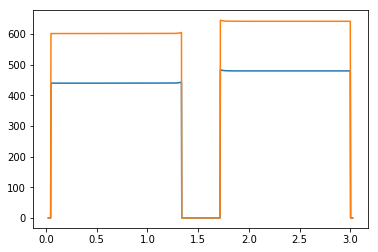

In [25]:
plt.plot(tStamps,tfreq)

## Part 5 - Sinusoidal modeling of a multicomponent signal

Perform a sinusoidal analysis of a complex synthetic signal, using `sineModelAnal()` exploring the different parameters of the model. Use the sound `multiSines.wav` and respond by explaining the difficulties encoutered and solutions found. 

This is an open question without a single specific answer. We will use the sound `multiSines.wav`, which is a synthetic audio signal with sharp attacks, close frequency components with a wide range of amplitudes, and time varying chirps with frequency tracks that cross over. All these characteristics make this signal difficult to analyze with `sineModelAnal()`. Get familiar with the signal by listening to it and visualizing its spectrogram. Use models_GUI.py interface or sonic visualizer to see its spectrogram. 

We have written a basic code for sinusoidal analysis, you are free to modify it. You should be able to generate a sound that is perceptually undistinguishable from the input sound.

Write a short explanation in the cell below, explaining the difficulties encoutered and solutions found. 


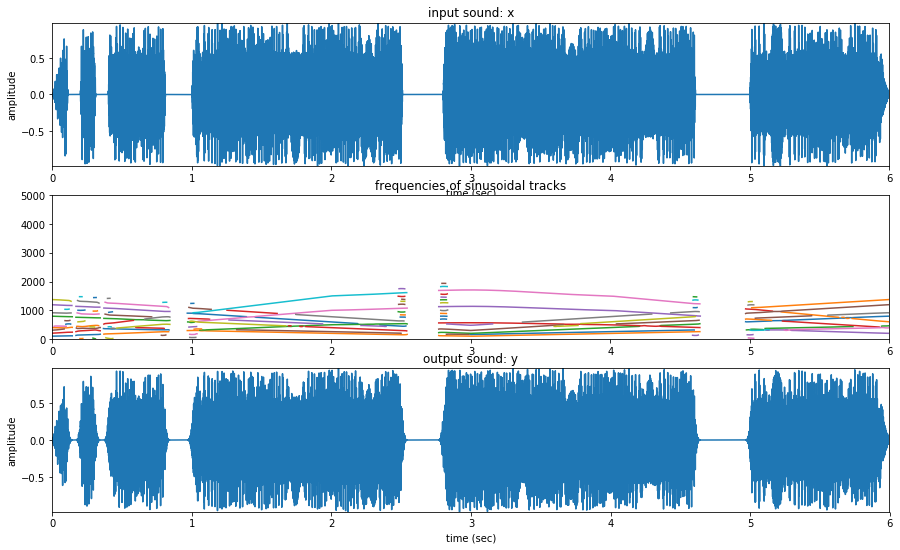

In [19]:
import IPython.display as ipd

input_file = '../sounds/multiSines.wav'

### set the analysis parameters

window = 'blackmanharris'                      
M = 4100                                    
N = 8192                                    
t = -80                                                   
minSineDur = 0.02                     
maxnSines = 16
freqDevOffset = 10
freqDevSlope = 0.001


# no need to modify the code after here
Ns = 512                                      # size of fft used in synthesis
H = 128                                       # hop size (has to be 1/4 of Ns)
    
fs, x = UF.wavread(input_file)                # read input sound
w = get_window(window, M)                     # compute analysis window

# analyze the sound with the sinusoidal model
tfreq, tmag, tphase = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)

# synthesize the output sound from the sinusoidal representation
y = SM.sineModelSynth(tfreq, tmag, tphase, Ns, H, fs)

# create figure to show plots
plt.figure(figsize=(15, 9))

# frequency range to plot
maxplotfreq = 5000.0

# plot the input sound
plt.subplot(3,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('input sound: x')
                
# plot the sinusoidal frequencies
plt.subplot(3,1,2)
if (tfreq.shape[1] > 0):
    numFrames = tfreq.shape[0]
    frmTime = H*np.arange(numFrames)/float(fs)
    tfreq[tfreq<=0] = np.nan
    plt.plot(frmTime, tfreq)
    plt.axis([0, x.size/float(fs), 0, maxplotfreq])
    plt.title('frequencies of sinusoidal tracks')

# plot the output sound
plt.subplot(3,1,3)
plt.plot(np.arange(y.size)/float(fs), y)
plt.axis([0, y.size/float(fs), min(y), max(y)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('output sound: y')

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

## Your explanation of Part 5 here